<a href="https://colab.research.google.com/github/leoa4238/AI-Project/blob/main/505_SSD_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SSD

- Single Shot MultiBox Detector : 단일 단계(single shot)로 객체의 위치(바운딩 박스)와 클래스(라벨)를 동시에 예측하는 객체 탐지 모델

<img src="https://cdn-images-1.medium.com/max/1000/1*GmJiirxTSuSVrh-r7gtJdA.png" />

- SSD(Single Shot Multibox Detector) 아키텍처는 다음과 같이 요약할 수 있습니다.

1. **입력 이미지 (왼쪽)**:  
   이미지는 원본 상태로 네트워크에 입력됩니다. 여기서 시작하는 변환 과정은 점진적으로 특징을 추출하며 진행됩니다.

2. **Base Network (기본 특징 추출부)**:  
   - `conv1`, `pool1`, `conv2_x`, `conv3_x`, `conv4_x`, `conv5_x`라고 표시된 큰 회색 블록들은 사전에 학습된 분류용 CNN(예: VGG-16)을 기반으로 합니다.
   - 이 단계에서 이미지로부터 엣지, 텍스처, 형태와 같은 저/중간 수준 특징들이 추출되며, 점차 하위 레이어로 갈수록 더 추상적이고 고차원적인 특징이 얻어집니다.
<br></br>
3. **Multi-scale Feature Maps 생성부 (SSD Layers 부분)**:  
   - 그림 오른쪽 부분에 작은 파란색 박스로 표현된 층들이 바로 SSD에서 추가되는 "extra feature layers"를 의미합니다.
   - `conv5_x` 이후에 추가되는 컨볼루션 레이어들이 특징 맵의 공간적 크기를 점진적으로 줄여나가며 다양한 스케일의 특징 맵을 생성합니다.
   - 이러한 각각의 특징 맵(파란 박스들)은 서로 다른 크기의 객체를 탐지하기 위해 사용됩니다.
<br></br>
4. **Default Boxes(Anchor Boxes) & Prediction Layers**:  
   - 파란색 박스들로 표현된 추가 컨볼루션 레이어들에서 각 셀 위치마다 여러 비율과 스케일의 기본 박스(default box)가 할당됩니다.
   - 이 레이어들 위에서 클래스 점수와 바운딩 박스 좌표(offset)를 예측하는 "Original Prediction Layer"(그림 상단의 화살표 끝부분)로 이어집니다.
   - 즉, 여러 스케일의 특징 맵에서 나온 정보가 최종적으로 한 번에(싱글 샷으로) 객체의 위치와 클래스 확률을 예측하는 단계로 전달됩니다.

정리하자면, **왼쪽에서 오른쪽으로 갈수록**:  
입력 이미지 → 사전학습된 기본 CNN을 거치며 특징 추출 → 네트워크 후반부에 SSD 전용 레이어 추가 및 다중 스케일 특징 맵 생성 → 각 스케일별로 기본 박스에 대해 클래스/좌표 예측 → 최종 예측 결과 산출  
의 순서로 진행되는 것이 SSD 의 아키텍처 입니다.

In [ ]:
import torch
from PIL import Image
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

In [ ]:
# 1. 사전 학습된 SSD 모델 로드 (COCO 데이터셋으로 학습)
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model.eval()

# COCO 클래스는 1번부터 90번까지 매핑되어 있으며, 0은 background를 의미
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# 2. 이미지 전처리
image_path = 'car_image.jpg'
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
])

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # 배치 차원 추가
input_batch.shape

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 87.8MB/s]


torch.Size([1, 3, 300, 300])

In [ ]:
# 3. 모델 추론
with torch.inference_mode():
    predictions = model(input_batch)[0]

# 결과 분석
boxes = predictions['boxes']       # 바운딩 박스 좌표 [N, 4] (xmin, ymin, xmax, ymax)
labels = predictions['labels']     # 각 박스별 클래스 인덱스 [N]
scores = predictions['scores']     # 각 박스별 점수 (신뢰도) [N]

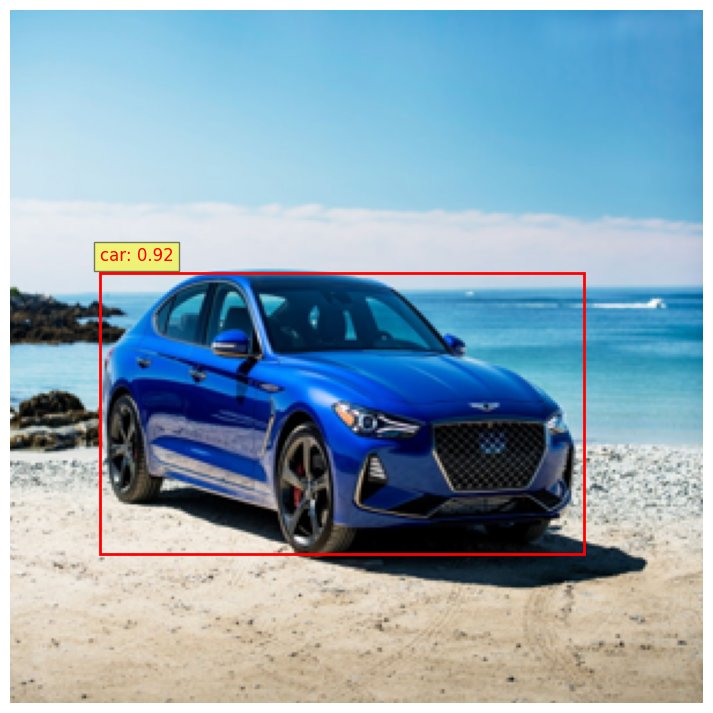

In [ ]:
# 4. 시각화
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(image.resize((300, 300)))

threshold = 0.5
for box, label, score in zip(boxes, labels, scores):
    if score > threshold:
        # box 좌표를 리스트 형태로 변환
        x_min, y_min, x_max, y_max = box.tolist()
        # 박스의 폭과 높이 계산
        width = x_max - x_min
        height = y_max - y_min

        #해당 좌표와 크기로 사각형을 그림
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        # 실제 matplotlib 축(ax)에 패치 추가
        ax.add_patch(rect)

        # 클래스 이름
        class_name = COCO_INSTANCE_CATEGORY_NAMES[label.item()]
        #점수 표시
        text = f"{class_name}: {score:.2f}"

        # ax.text(x, y, text, ...)를 통해 이미지 위에 텍스트 표시
        # bbox 인자를 통해 텍스트 주변에 배경 박스(노란색, 투명도 0.5) 생성
        ax.text(x_min, y_min-5, text, fontsize=12, color='red',
                bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis('off')
plt.show()